# Tutorial 9 - Inverse PDE Problem

In this tutorial we will be working with the DIY KAN concept once again, this time in order to solve an inverse PDE problem.

In [1]:
from typing import List
from jaxkan.layers.Spline import SplineLayer

import jax
import jax.numpy as jnp

from jaxkan.pikan.pde import gradf
from jaxkan.pikan.sampling import get_collocs_sobol

from flax import nnx
import optax

import matplotlib.pyplot as plt
import numpy as np

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## Data Generation

For the purposes of this example, we will be working with the Diffusion Equation,

$$ \frac{\partial u}{\partial t} -D \frac{\partial^2 u}{\partial x^2} = 0,$$

in the $\Omega = [0,1]\times [0,1]$ domain, subject to the boundary conditions

$$ u\left(t=0, x\right) = \sin\left(\pi x\right), $$

$$ u\left(t, x=0\right) = u\left(t, x=1\right) = 0. $$

We have intentionally left $D$ undefined, as we intend to also estimate it (apart from solving the PDE), using "experimental data". The PDE's analytical solution is given by

$$ u(t,x) = \sin\left(\pi x\right) \cdot \exp\left(-D\pi^2 t\right), $$

so it will be used to generate mock experimental data with gaussian noise for $D = 0.25$.

In [2]:
seed = 42

# Generate Collocation points for PDE
pde_collocs = get_collocs_sobol(ranges=[(0,1), (0,1)], total_points=2**12, seed=seed)

# Generate Collocation points for IC
ic_collocs = get_collocs_sobol(ranges=[(0,0), (0,1)], total_points=2**6, seed=seed)
ic_data = jnp.sin(np.pi*ic_collocs[:,1]).reshape(-1,1)

# Generate Collocation points for BCs
bc1_collocs = get_collocs_sobol(ranges=[(0,1), (0,0)], total_points=2**6, seed=seed)
bc1_data = jnp.zeros(bc1_collocs.shape[0]).reshape(-1,1)

bc2_collocs = get_collocs_sobol(ranges=[(0,1), (1,1)], total_points=2**6, seed=seed)
bc2_data = jnp.zeros(bc2_collocs.shape[0]).reshape(-1,1)

# Concatenate IC/BCs
bc_collocs = jnp.concatenate([ic_collocs, bc1_collocs, bc2_collocs], axis=0)
bc_data = jnp.concatenate([ic_data, bc1_data, bc2_data], axis=0)

In [3]:
# Generate experimental data for inverse problem
def u(t, x, tau):
    return jnp.sin(jnp.pi*x)*jnp.exp(-tau*(jnp.pi**2)*t)

key = jax.random.PRNGKey(seed)
idxs = jax.random.choice(key, jnp.arange(pde_collocs.shape[0]), (1000,), replace=False)
exp_collocs = pde_collocs[idxs]

u_vals = u(exp_collocs[:,0], exp_collocs[:,1], 0.25).reshape(-1,1)
noise = u_vals.std()*jax.random.normal(key, shape=(1000,1))
exp_data = u_vals + noise

## KAN Model

We will define a KAN Class based on the Spline Layer, which will also include a trainable parameter, $\tau$.

In [4]:
class MyKAN(nnx.Module):
    
    def __init__(self, layer_dims: List[int], k: int = 3, G: int = 5, add_bias: bool = True, seed: int = 42):
        
        self.layers = nnx.List([
                SplineLayer(
                    n_in=layer_dims[i], 
                    n_out=layer_dims[i + 1],
                    k=k,
                    G=G,
                    residual=nnx.silu,
                    external_weights=True,
                    add_bias=add_bias,
                    seed=seed)
                for i in range(len(layer_dims) - 1)
            ])

        # This is the parameter we need to identify to solve the inverse problem
        # We initialize it at 1.0
        self.tau = nnx.Param(jnp.array([1.0]))

    
    def __call__(self, x):

        for layer in self.layers:
            x = layer(x)

        return x

In [5]:
# Initialize a MyKAN model instance
n_in = pde_collocs.shape[1]
n_out = 1
n_hidden = 6

layer_dims = [n_in, n_hidden, n_hidden, n_out]

model = MyKAN(layer_dims = layer_dims, k = 3, G = 5, add_bias = True, seed = 42)

## Training

PIKANs provide a unified framework for solving the forward and the inverse PDE problem. Nonetheless, we will need to incorporate the "experimental" data in the loss function.

In [6]:
opt_type = optax.adam(learning_rate=0.001)

optimizer = nnx.Optimizer(model, opt_type, wrt=nnx.Param)

In [7]:
# PDE Loss
def pde_loss(model, collocs):
    # Eq. parameter
    tau = model.tau

    def u(x):
        y = model(x)
        return y
        
    # Physics Loss Terms
    u_t = gradf(u, [0])
    u_xx = gradf(u, [1, 1])
    
    # Residual
    pde_res = u_t(collocs) - tau*u_xx(collocs)
    
    return pde_res

# Define train loop
@nnx.jit
def train_step(model, optimizer, collocs, bc_collocs, bc_data, exp_collocs, exp_data):

    def loss_fn(model):
        # PDE part
        pde_res = pde_loss(model, collocs)
        total_loss = jnp.mean((pde_res)**2)

        # IC/BC part
        bc_res = model(bc_collocs) - bc_data
        total_loss += jnp.mean(bc_res**2)

        # Experimental data loss
        exp_res = model(exp_collocs) - exp_data
        total_loss += jnp.mean(exp_res**2)

        return total_loss
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(model, grads)
    
    return loss

In [8]:
# Initialize train_losses
num_epochs = 5000

for epoch in range(num_epochs):
    # Calculate the loss
    loss = train_step(model, optimizer, pde_collocs, bc_collocs, bc_data, exp_collocs, exp_data)

## Evaluation

The following plot shows the trained neural network on the entire domain, approximating the solution, $u$, of the equation.

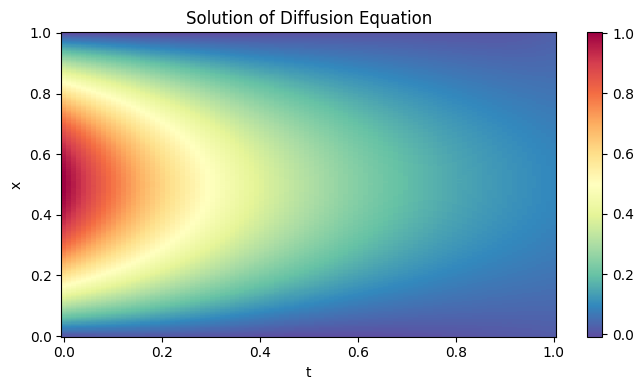

In [9]:
N_t, N_x = 100, 256

t = np.linspace(0.0, 1.0, N_t)
x = np.linspace(0.0, 1.0, N_x)
T, X = np.meshgrid(t, x, indexing='ij')
coords = np.stack([T.flatten(), X.flatten()], axis=1)

output = model(jnp.array(coords))
resplot = np.array(output).reshape(N_t, N_x)

plt.figure(figsize=(7, 4))
plt.pcolormesh(T, X, resplot, shading='auto', cmap='Spectral_r')
plt.colorbar()

plt.title('Solution of Diffusion Equation')
plt.xlabel('t')

plt.ylabel('x')

plt.tight_layout()
plt.show()

We can also visualize the difference between the analytical and the approximated solution.

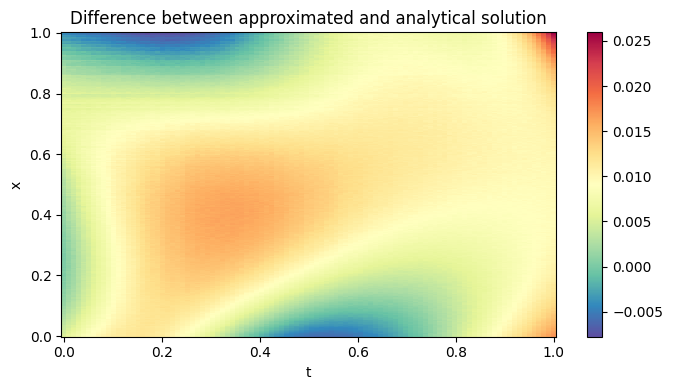

In [10]:
output = model(jnp.array(coords))
diff = output - u(coords[:,0], coords[:,1], 0.25).reshape(-1, 1)
resplot = np.array(diff).reshape(N_t, N_x)

plt.figure(figsize=(7, 4))
plt.pcolormesh(T, X, resplot, shading='auto', cmap='Spectral_r')
plt.colorbar()

plt.title('Difference between approximated and analytical solution')
plt.xlabel('t')

plt.ylabel('x')

plt.tight_layout()
plt.show()

It appears that the approximation is good, since the maximum absolute error is $\sim 0.02$.

Finally, we can see that $\tau$ is approximated quite well:

In [11]:
print(f"The approximated value for τ is {model.tau[0]}.")

The approximated value for τ is 0.24092978239059448.
